## IMBD Movie Review - Sentiment Analyzer

Dataset - https://github.com/laxmimerit/IMDB-Movie-Reviews-Large-Dataset-50k/blob/master/train.xlsx

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier


C:\ProgramData\Anaconda3\envs\NLPML\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Dataset

In [2]:
df = pd.read_excel('train.xlsx')
df.head()

,Reviews,Sentiment
0,"When I first tuned in on this morning news, I ...",neg
1,"Mere thoughts of ""Going Overboard"" (aka ""Babes...",neg
2,Why does this movie fall WELL below standards?...,neg
3,Wow and I thought that any Steven Segal movie ...,neg
4,"The story is seen before, but that does'n matt...",neg


### EDA and Feature Engineering

C:\ProgramData\Anaconda3\envs\NLPML\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

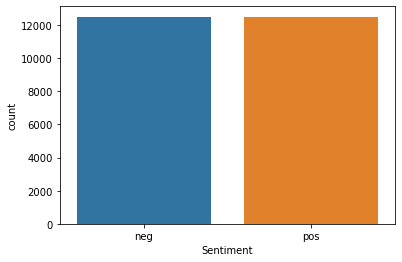

In [3]:
sns.countplot(df['Sentiment'])

#### The above plot shows that data is balanced.

In [4]:
re_tag = "<[^<>]+>"
re_spl_char = "[^a-zA-Z1-9 ]"

In [5]:
# Funtion to remove html tags and special characters from dataset before training model.
def clean_data(s):
    # removing html tags
    new_str1 = re.sub(re_tag, ' ', str(s))
    # removing special characters
    new_str2 = re.sub(re_spl_char, '', new_str1)
    return new_str2.lower()

In [6]:
lst = []
# cleaning the dataset
for review in df['Reviews']:
    new_str = clean_data(review)
    lst.append(new_str)

In [7]:
df['reviews'] = lst

In [8]:
# Encoding the Sentiment column: "pos"=>1 and "neg"=>0
df['Sentiment'] = df['Sentiment'].apply(lambda x: 1 if x=="pos" else 0)

In [9]:
print(df.shape)
df.head()

(25000, 3)


,Reviews,Sentiment,reviews
0,"When I first tuned in on this morning news, I ...",0,when i first tuned in on this morning news i t...
1,"Mere thoughts of ""Going Overboard"" (aka ""Babes...",0,mere thoughts of going overboard aka babes aho...
2,Why does this movie fall WELL below standards?...,0,why does this movie fall well below standards ...
3,Wow and I thought that any Steven Segal movie ...,0,wow and i thought that any steven segal movie ...
4,"The story is seen before, but that does'n matt...",0,the story is seen before but that doesn matter...


#### WordCloud

In [10]:
text = ''
for para in df['reviews']:
    tokens = para.split()
    text += " ".join(tokens)+" "

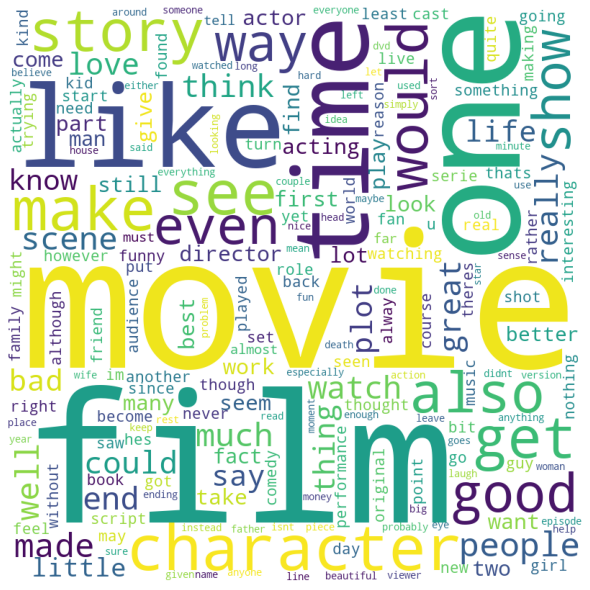

In [11]:
stwords = stopwords.words('english')
wordcloud = WordCloud(width=800, height=800, 
                      background_color='white', 
                      stopwords=stwords, 
                      min_font_size=10).generate(text)
 
# plot the WordCloud image                      
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Using Tfidf for vectorizing data

In [12]:
tfidf = TfidfVectorizer(max_features=10000)
x = df['reviews']
y = df['Sentiment']
x = tfidf.fit_transform(x)

In [13]:
# splitting the dataset
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, random_state=89)

In [15]:
def model_result(svc, naive_bayes, logis_reg, ran_forst, xgb):
    ypred_svc = svc.predict(xtest)
    ypred_nb = naive_bayes.predict(xtest.toarray())
    ypred_lr = logis_reg.predict(xtest)
    ypred_ran = ran_forst.predict(xtest)
    ypred_xgb = xgb.predict(xtest)
    prediction = [ypred_svc, ypred_nb, ypred_lr, ypred_ran, ypred_xgb]
    model = ['SVC', 'Naive_bayes', 'Logistic_regression', 'Random_forest', 'XGBoost']
    dic = {
        "Model": model,
        "Accuracy": [accuracy_score(ytest, i) for i in prediction],
        "f1_score": [f1_score(ytest, i) for i in prediction],
        "Precision": [precision_score(ytest, i) for i in prediction]
    }
    df = pd.DataFrame(dic)
    return df

### Hyper parameter tuning

In [16]:
clf_svc = LinearSVC()
param_grid = {
    'C': [10, 1, 0.1, 0.01, 0.001],
}

In [17]:
grid_search = GridSearchCV(estimator=clf_svc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(xtrain, ytrain)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [10, 1, 0.1, 0.01, 0.001]}, verbose=2)

In [18]:
grid_search.best_params_

{'C': 0.1}

In [19]:
clf_svc = LinearSVC(C=0.1)
clf_svc.fit(xtrain, ytrain)

LinearSVC(C=0.1)

In [20]:
clf_nb = GaussianNB()
clf_nb.fit(xtrain.toarray(), ytrain)

GaussianNB()

In [21]:
clf_lr = LogisticRegression()
param_grid = {
    'C': [10, 1, 0.1, 0.01, 0.001],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'max_iter': [2000]
}
grid_search = GridSearchCV(estimator=clf_lr, param_grid=param_grid, cv=5, verbose=2)

In [22]:
grid_search.fit(xtrain, ytrain)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END ....................C=10, max_iter=2000, penalty=l1; total time=   0.0s
[CV] END ....................C=10, max_iter=2000, penalty=l1; total time=   0.0s
[CV] END ....................C=10, max_iter=2000, penalty=l1; total time=   0.0s
[CV] END ....................C=10, max_iter=2000, penalty=l1; total time=   0.0s
[CV] END ....................C=10, max_iter=2000, penalty=l1; total time=   0.0s
[CV] END ....................C=10, max_iter=2000, penalty=l2; total time=   1.0s
[CV] END ....................C=10, max_iter=2000, penalty=l2; total time=   0.9s
[CV] END ....................C=10, max_iter=2000, penalty=l2; total time=   1.3s
[CV] END ....................C=10, max_iter=2000, penalty=l2; total time=   1.0s
[CV] END ....................C=10, max_iter=2000, penalty=l2; total time=   0.6s
[CV] END ............C=10, max_iter=2000, penalty=elasticnet; total time=   0.0s
[CV] END ............C=10, max_iter=2000, penalt

C:\ProgramData\Anaconda3\envs\NLPML\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\NLPML\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\envs\NLPML\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\envs\NLPML\lib\site-packages\sklearn\linear_model\_logistic.py", line 447,

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [10, 1, 0.1, 0.01, 0.001], 'max_iter': [2000],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             verbose=2)

In [23]:
grid_search.best_params_

{'C': 10, 'max_iter': 2000, 'penalty': 'l2'}

In [24]:
clf_lr = LogisticRegression(C=10, max_iter=2000, penalty='l2')
clf_lr.fit(xtrain, ytrain)

LogisticRegression(C=10, max_iter=2000)

In [25]:
clf_ran = RandomForestClassifier()
param_grid = {
    'n_estimators': [100],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 3, 4, 5],
    'bootstrap': ['True', 'False'],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}
grid_search = GridSearchCV(estimator=clf_ran, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

In [26]:
grid_search.fit(xtrain, ytrain)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': ['True', 'False'],
                         'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [100]},
             verbose=2)

In [27]:
grid_search.best_params_

{'bootstrap': 'False',
 'criterion': 'entropy',
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 100}

In [28]:
clf_ran = RandomForestClassifier(bootstrap=False, criterion='entropy', min_samples_leaf=3, min_samples_split=4)

In [29]:
clf_ran.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=False, criterion='entropy', min_samples_leaf=3,
                       min_samples_split=4)

In [30]:
clf_xgb = XGBClassifier()
param_grid = {
    'booster': ['gbtree', 'gblinear'],
    'eta': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': range(1, 10, 3),
    'gamma': [0, 1, 2],
}

In [31]:
grid = GridSearchCV(estimator=clf_xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid.fit(xtrain, ytrain)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


C:\ProgramData\Anaconda3\envs\NLPML\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:26:36] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "gamma", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:26:36] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

In [32]:
grid.best_params_

{'booster': 'gblinear', 'eta': 0.01, 'gamma': 1, 'max_depth': 1}

In [33]:
clf_xgb = XGBClassifier(booster='gblinear', eta=0.01, gamma=1, max_depth=1)
clf_xgb.fit(xtrain, ytrain)

[07:27:26] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:576: 
Parameters: { "gamma", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:27:26] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gblinear', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eta=0.01, gamma=1, gpu_id=-1,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.5, max_delta_step=None, max_depth=1,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=12, num_parallel_tree=None,
              predictor=None, random_state=0, reg_alpha=0, reg_lambda=0,
              scale_pos_weight=1, subsample=None, tree_method=None,
              validate_parameters=1, verbosity=None)

In [34]:
result = model_result(clf_svc, clf_nb, clf_lr, clf_ran, clf_xgb)
result.set_index('Model', inplace=True)
result

,Accuracy,f1_score,Precision
Model,,,
SVC,0.88528,0.886855,0.873485
Naive_bayes,0.77616,0.767105,0.798060
Logistic_regression,0.88496,0.885491,0.880025
Random_forest,0.83872,0.841609,0.825524
XGBoost,0.88624,0.886440,0.883477


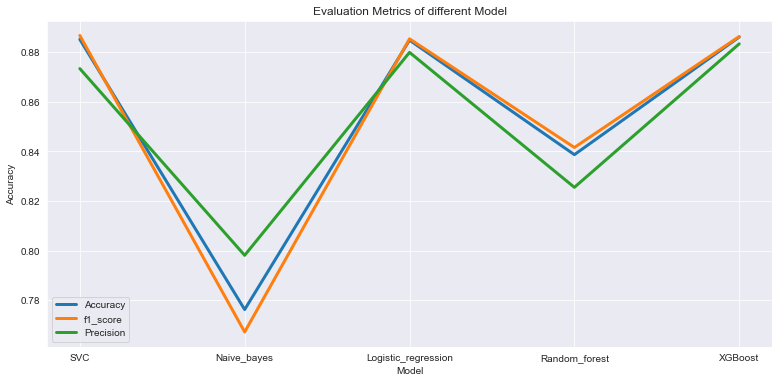

In [35]:
sns.set_style('darkgrid')
plt.figure(figsize=(13, 6))
sns.lineplot(data=result['Accuracy'], linewidth=3)
sns.lineplot(data=result['f1_score'], linewidth=3)
sns.lineplot(data=result['Precision'], linewidth=3)
plt.legend(['Accuracy', 'f1_score', 'Precision'])
plt.xlabel('Model')
plt.title('Evaluation Metrics of different Model')
plt.rc('font', size=13)
plt.rc('axes', labelsize=14)

##### The above table and plot suggest that SVC, Logistic Regression and XGBoost works best for this dataset. Fine tuned XGBoost works slightly better than both.

#### Example text

In [38]:
# Example test case.
x = "Infinity was one of the best films ever! This is a disgrace of a follow-up. Slow, elongated \
and boring. I sat through 1.5 hours and gave up, waiting for something to happen. My advice, do not \
bother!"
x_clean = clean_data(x)
print(f"Cleaned Data: {x_clean}")
x_vec = tfidf.transform([x])

Cleaned Data: infinity was one of the best films ever this is a disgrace of a followup slow elongated and boring i sat through 15 hours and gave up waiting for something to happen my advice do not bother


In [39]:
print(f"Predicted sentiment of review is: {clf_xgb.predict(x_vec)[0]}")

Predicted sentiment of review is: 0
